In [1]:
import numpy as np
from matplotlib import pyplot as plt

from IPython.display import display, Latex


In [2]:
# sigularities
def sing(x,a,n):
    if not isinstance(x, np.ndarray):
        x = np.array([x])
    ni = np.zeros(x.size)
    for i in range(x.size):
        if x[i] >=a and n>=0:
            ni[i] = (x[i]-a)**n
    return ni/np.math.factorial(n)

In [3]:
def lx(ord_f,pc, tire_l, case,ab,p1,p2):
    react_f = GVWR*((1-pc)*sing(dx,0,ord_f)+pc/2*(sing(dx,lw1,ord_f)+sing(dx, lw2, ord_f)))
    other_f = p1*sing(dx,a2,ord_f)+p2*sing(dx,lc,ord_f)+W_tip/base_len*(sing(dx,0, ord_f+1)-sing(dx,base_len, ord_f+1))
    if case == 1:
        return react_f - other_f - Rc*sing(dx, tire_l, ord_f)
    else:
        return react_f - other_f

In [4]:
def pp(tire_l,load_fac,ab):
    react_f = Rc*((tire_l-ab)*load_fac+wheel_base)+W_tip*(G_tip-ab)
    p2 = react_f/(lc-ab)
    p1 = load_fac * Rc + W_tip - p2
    # print(f'p1<0: {ab==a1}, p1:{p1}')
    return p1,p2

In [5]:
def trail(ord_f,pc,tire_len, case,ab,p1,p2):
    react_f = p1*sing(dx,a2,ord_f)+p2*sing(dx,lc,ord_f)-W_tip/tip_len*(sing(dx,a1, ord_f+1)-sing(dx,a1+tip_len, ord_f+1))#todo sigularity(a), mom = @sig(a,1,2)
    if case == 1:
        rc_f = Rc*sing(dx,tire_len,ord_f)
    else:
        rc_f = Rc*(sing(dx,tire_len+wheel_base,ord_f)+sing(dx,tire_len,ord_f))
    return react_f - rc_f

In [6]:
def plot_trail(pl,l):

    lims = pl.axis()
    dy = lims[3]-lims[2]
    dx = lims[1]-lims[0]
    sca = dy/dx

    points = np.array([[0, base_len, base_len,base_len-6,base_len-12,base_len-36,base_len-48,a0,a0,0,0],
              [0,0,8,8,12,12,8,8,6,6,0]])
    
    points_2 = np.array([[-6,6,6,-6,-6],
               [0,0,2,2,0]])
    
    points_2[0] += a2

    dash_p = np.array([[a0,a0],[0,8]])
    tip_p = np.array([[a1,lf,lf-6,a1,a1],
            [8,8,2,2,8]])
    
    for i in [points,points_2,dash_p,tip_p]:
         i[1] = sca*i[1]

    pl.plot(*points,'c', label='Base (Reference)')
    pl.plot(*points_2,'c')
    pl.plot(*dash_p, 'c--')
    pl.plot(*tip_p,'y', label='Tip Deck (Refernce)')
    plot_wheels(pl,sca,l)

In [7]:
len_full = 300

# predefined arrays
dx = np.linspace(-1,len_full, 200)
cat_tire_l_arr = np.arange(60,len_full-50,10)


In [8]:
def plot_wheels(pl,sca,l):
    wheel_loc = [lw1,lw2]
    wheel_loc2 = [l,l+48]

    r = np.array([12,8])

    wheels = []
    t = np.linspace(0, 2*np.pi, 100)
    for i in wheel_loc:
        pl.plot(i+r[0]*np.cos(t),(-0.5+np.sin(t))*r[0]*sca,'c')

    pl.plot(wheel_loc2[0]+r[1]*np.cos(t),(8+r[1]+r[1]*np.sin(t))*sca,'m', label='Bobcat Wheels (load locations)')
    pl.plot(wheel_loc2[1]+r[1]*np.cos(t),(8+r[1]+r[1]*np.sin(t))*sca,'m')

In [9]:
def plot_x(react_mat,react_mattip,max_p, f_arr):
    # SFD BMD, \u03C3 vs distance for each condition of len,percent
    
    lft = [react_mat,react_mattip]
    plt_n = ['main', 'tip']
    for ii in range(len(react_mat)):
        fig, ax = plt.subplots(1,2)
        for i in range(2):
            ax[i].grid(True)
            m_half = lft[i][ii]

            ax[i].plot(dx,m_half[0], 'b',label='Shear (lb)')
            ax[i].plot(dx,m_half[1]*1e-2,'r',label='Moment(100*lb*in)')
            ax[i].plot(dx,m_half[2]*1e-1, 'g',label='Sigma (10*psi)')

            
            plot_trail(ax[i],f_arr[ii])
            ax[i].legend()
            ax[i].set_title(f'SFD BMD, \u03C3 allong trailer(in) for current loading on {plt_n[i]}')
        fig.suptitle(f'Plots for L= {round(f_arr[ii],2)}(in) rear Load:{int(max_p[ii,0]*100)}%')

In [10]:
def run_f(perc=None):
    max_p = [[0,0]]
    react_mat = []
    display(Latex(f'Conststants: \n$R={GVWR}\na_1={a1}, a_2={a2}\nL_c={lc}, L_{{w,1}}= {lw1}, L_{{w,2}} = {lw2}, $'))

    max_ptip = [[0,0]]
    react_mattip = []
    # loop through locations
    #const
    const_v = Rc*wheel_base+W_tip*(G_tip+G_base)
    const_react = GVWR*(lw1+lw2)/2
    if perc:
        f_arr = [perc]
    else:
        f_arr = cat_tire_l_arr
    for par_v in f_arr:
        if perc:
            p = par_v
            cat_tire_l = (const_react*p-const_v)/(2*Rc)
        else:
            cat_tire_l = par_v
            p = (2*Rc*cat_tire_l+const_v)/const_react
        ab = a2
        if cat_tire_l < a1:
            case = 1

        else:
            case = 2
        if cat_tire_l > lc+(lc-G_tip)*W_tip/(Rc*case)-48/case:
            ab = a1

        # initialize constants for each

        p1,p2 = pp(cat_tire_l,case,ab)
        r1 = round((1-p)*GVWR,1)
        r2 = round(p*GVWR,1)
        
        #singularity
        display(Latex(f'$\\text{{Equation solution: }} R_1={r1},R_2={r2}, p_1={round(p1,1)}, p_2={round(p2,1)}$'))
        load = lx(0,p,cat_tire_l,case,ab,p1,p2)
        mom = lx(1,p,cat_tire_l,case,ab, p1,p2)

        tip_l = trail(0,p,cat_tire_l,case,ab,p1,p2)
        tip_m = trail(1,p, cat_tire_l,case,ab,p1,p2)
        #, v: {}, m:{}')
        sig = mom/(rail_cnt*shear_mod)  # stress
        sigtip = tip_m/(rail_cnt2*shear_mod)

        react_mat.append([load, mom, sig])
        max_sig = np.max(np.abs(sig))

        max_p.append([p*1, max_sig*1])  # max stress for this loading condition and this location

        react_mattip.append([tip_l, tip_m, sigtip])
        max_sigtip = np.max(np.abs(sigtip))

        max_ptip.append([p*1, max_sigtip*1])  # max stress for this loading condition and this location

    # tabulation of this location, and max of location
    max_p = np.array(max_p)
    m_n = np.argmax(max_p,0)
    m_a = max_p[m_n[1],:]

    # adding to list of all locs

    # tabulation of this location, and max of location
    max_ptip = np.array(max_ptip)
    m_ntip = np.argmax(max_ptip,0)
    m_atip = max_ptip[m_ntip[1],:]
    print_conditions(max_p,f_arr,m_n,m_a,max_ptip,m_ntip,m_atip)
    
    return react_mat,react_mattip,max_p, f_arr

In [11]:
def print_conditions(max_p,f_arr,m_n,m_a,max_ptip,m_ntip,m_atip):
    # print(full r)
    def prt_1(ma):
        for i in range(ma.shape[0]-1):
            fis = ma[i+1,1]
            fs2 = '\dashv \\vdash' if fis>= yield_s else ''
            # st3 = '\Rightarrow'
            display(Latex(f'$L= {round(f_arr[i],1)}(in), x_{{wheel}}={int(ma[i+1,0]*100)} \%, \sigma_{{max}}={round(fis,2)}(psi) \Rightarrow {round(fis/1000,1)}(ksi){fs2}$'))
            
    def prt_2(mn,ma):
        print(f'\n----------')
        display(Latex(f'$\sigma_{{Max,Overall}}:: L={round(f_arr[mn[1]-1], 2)}(in), R_2={int(ma[0]*100)}%,  \sigma = {round(ma[1], 2)}(psi)$'))

    display(Latex(f'NOTE: $\dashv \\vdash \\text{{means failure at }} \sigma_y={round(yield_s/1000,1)}$'))

    # max for each percent, len
   
    prt_1(max_p)
    prt_2(m_n,m_a)
    # max for each percent, len
    print(f'\n\n--------------------\ntrailer\n--------------------\n')
    
    prt_1(max_ptip)

    prt_2(m_ntip,m_atip)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>


----------


<IPython.core.display.Latex object>



--------------------
trailer
--------------------



<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>


----------


<IPython.core.display.Latex object>

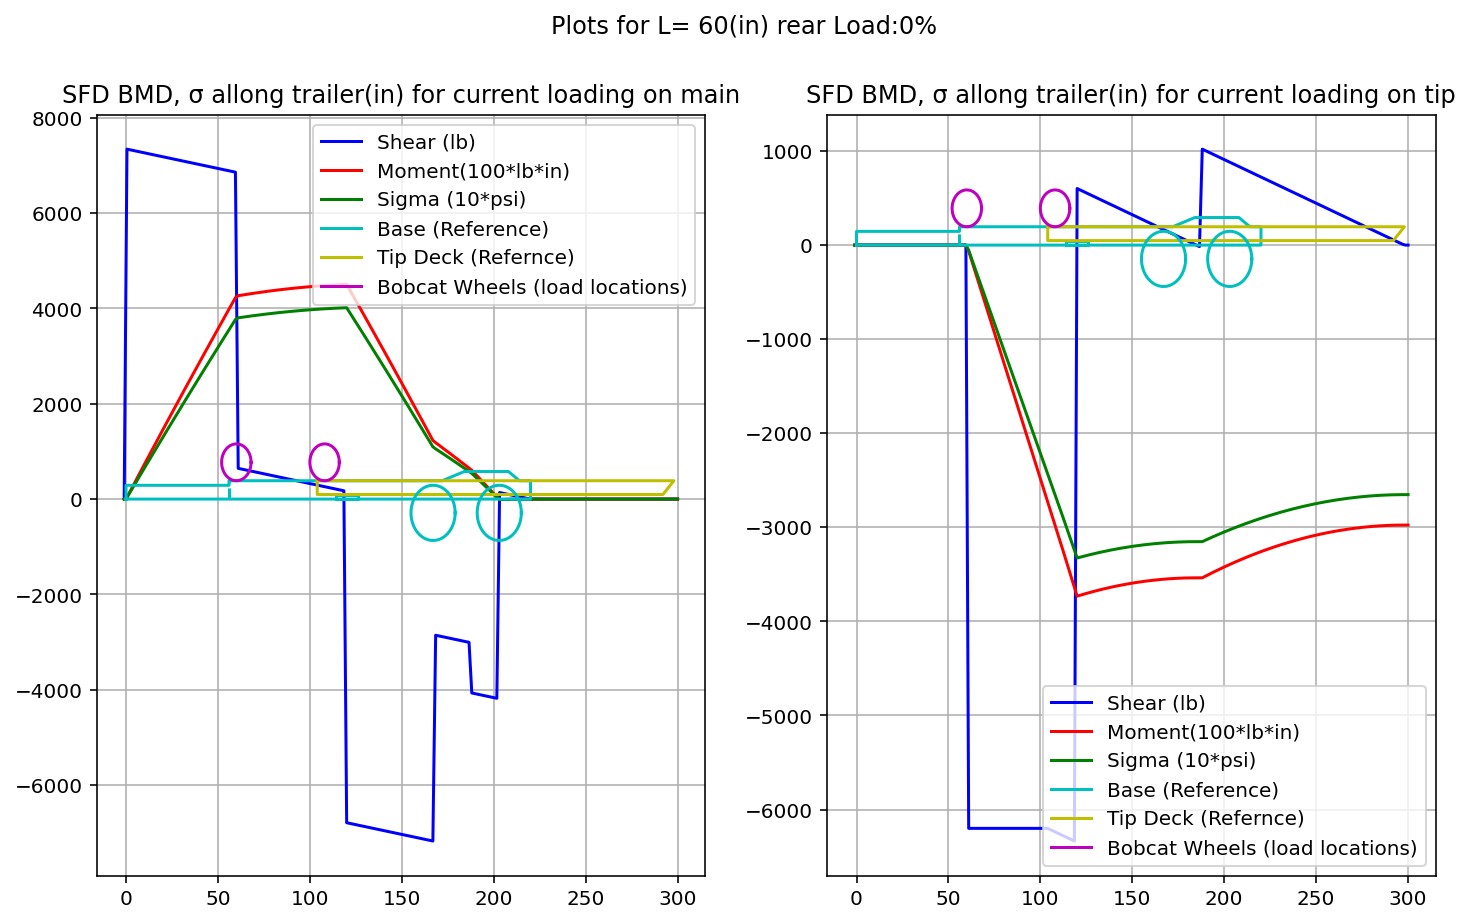

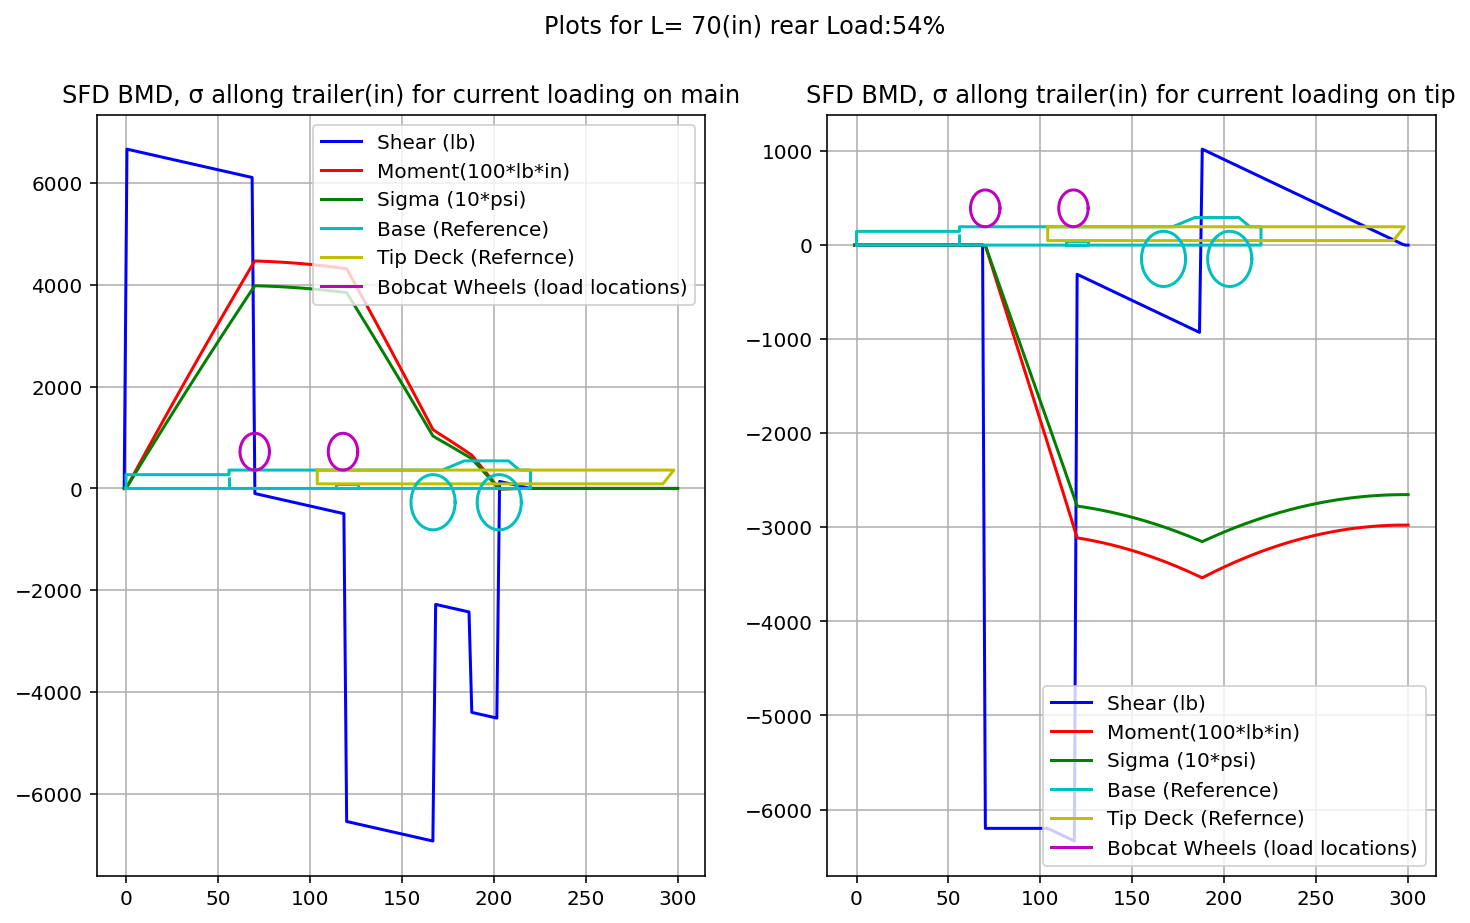

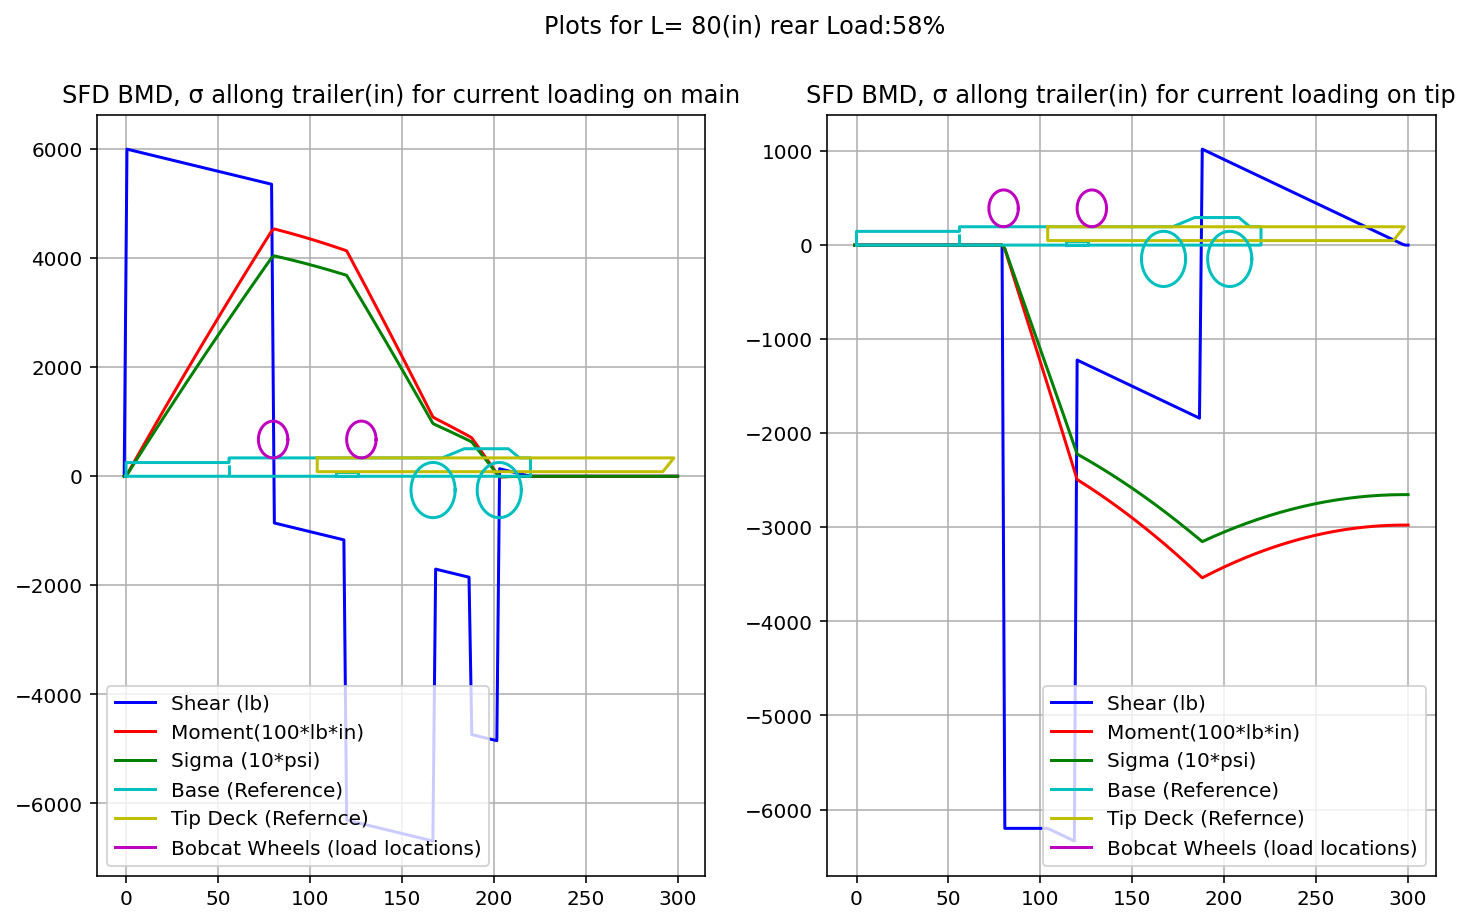

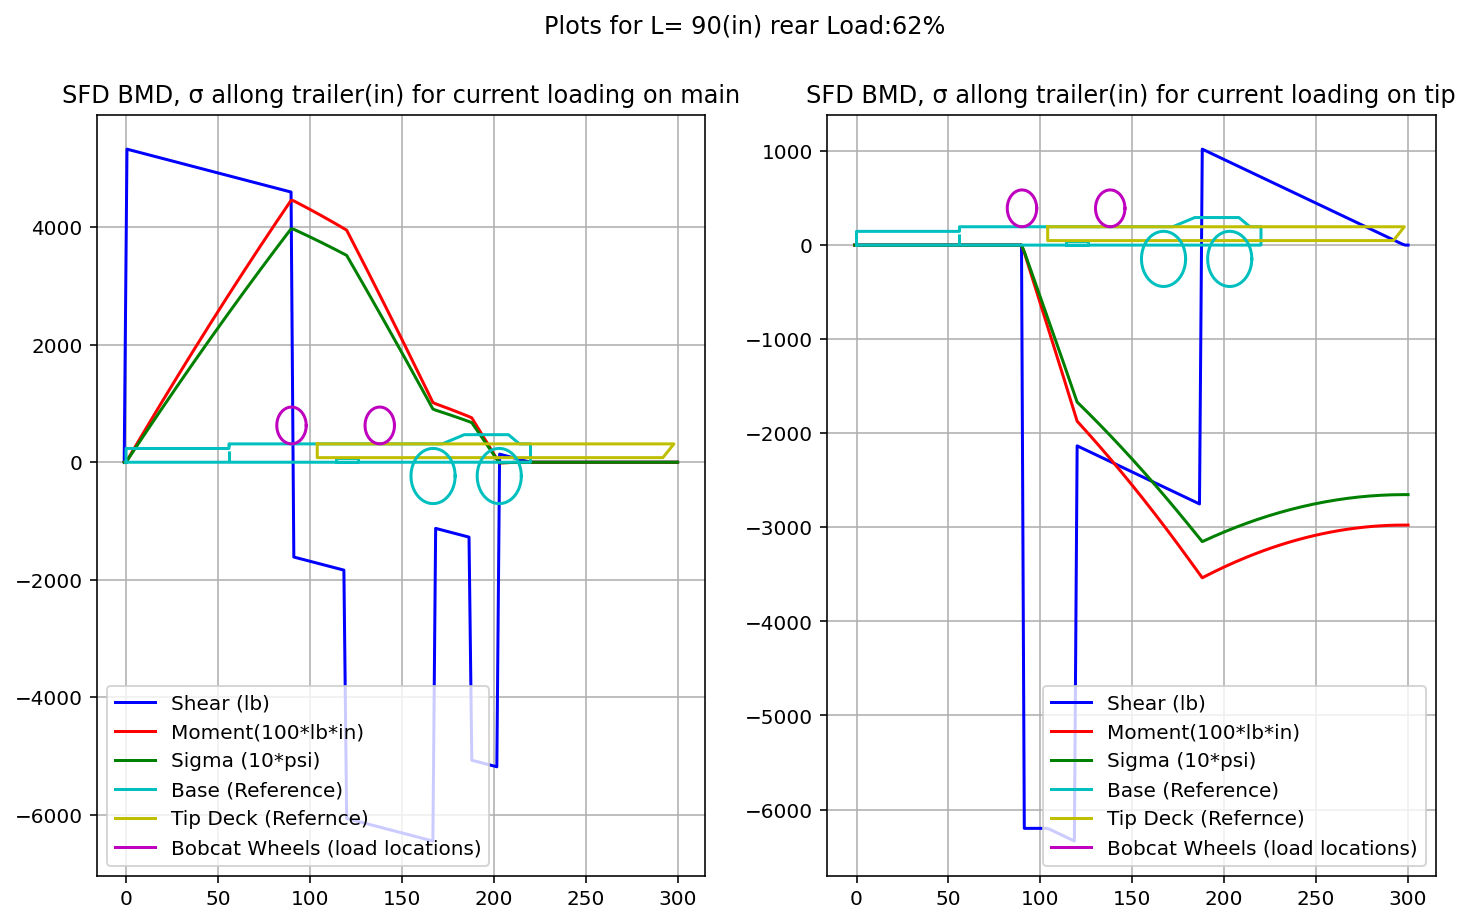

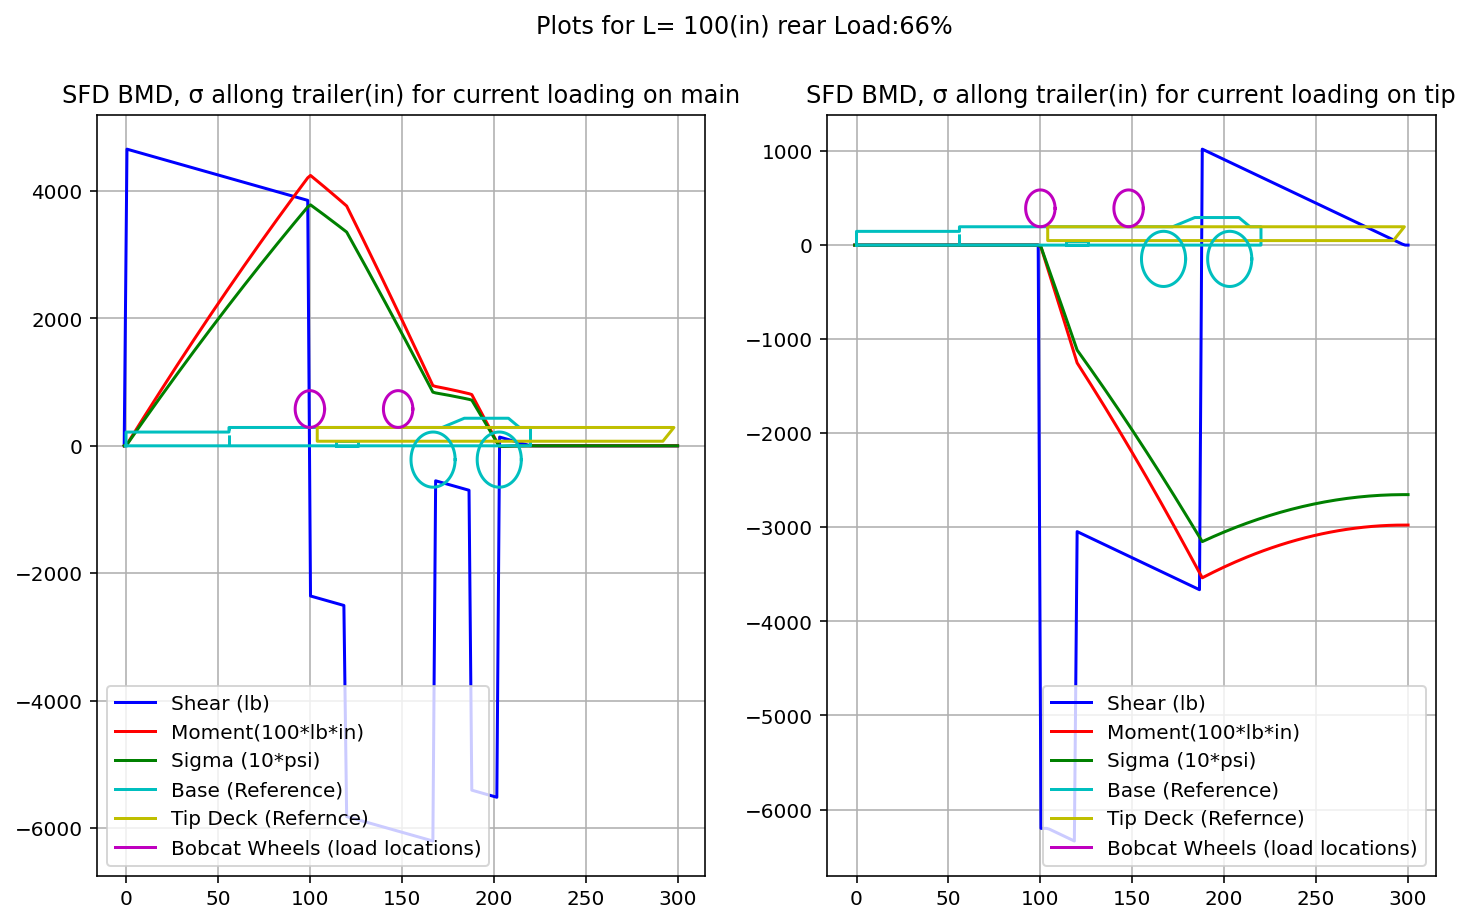

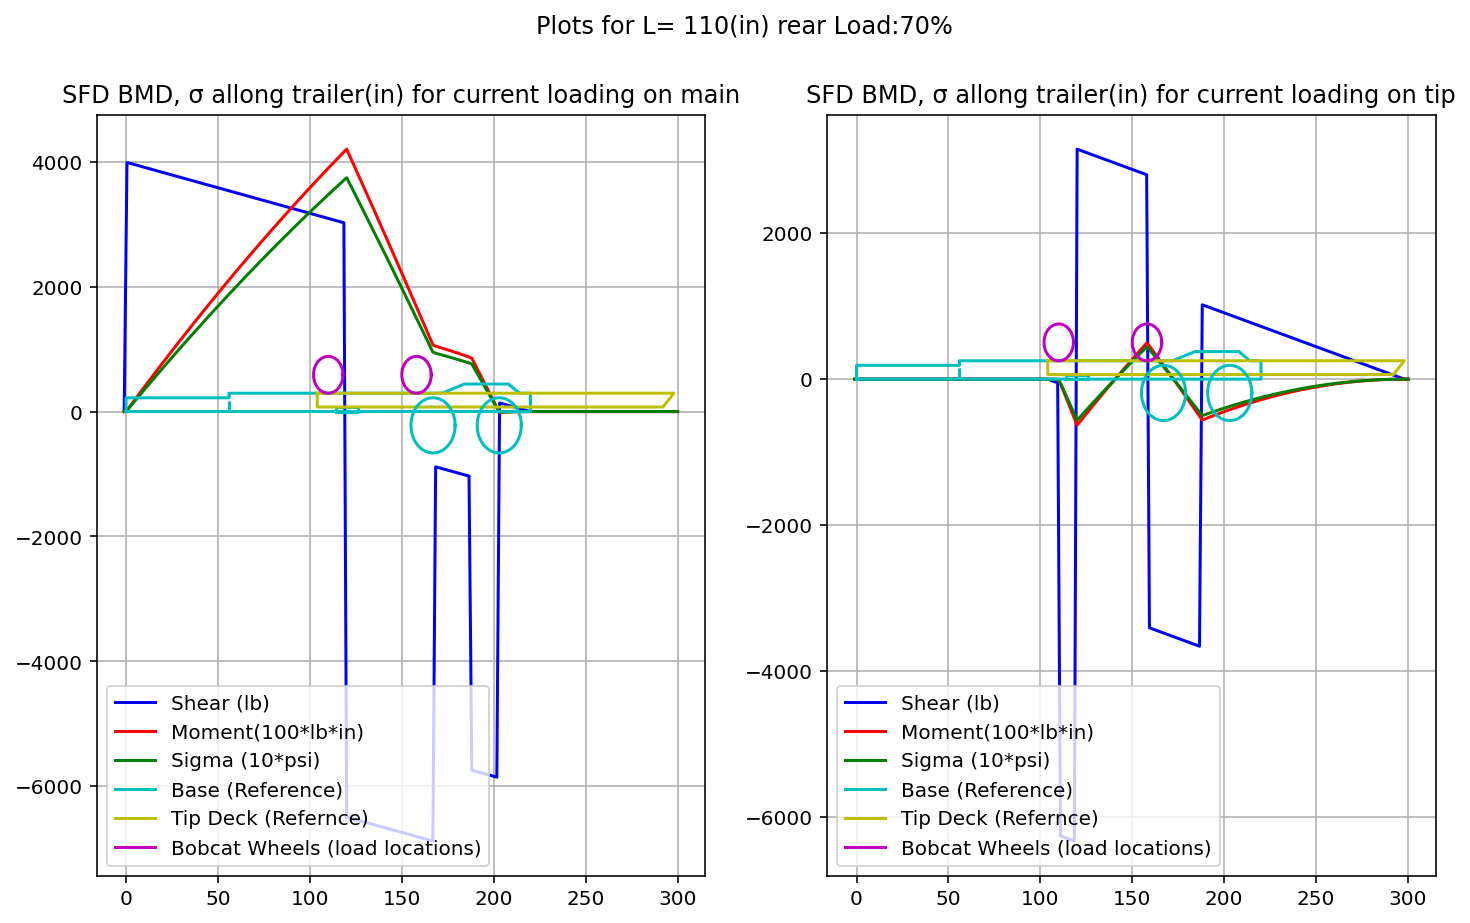

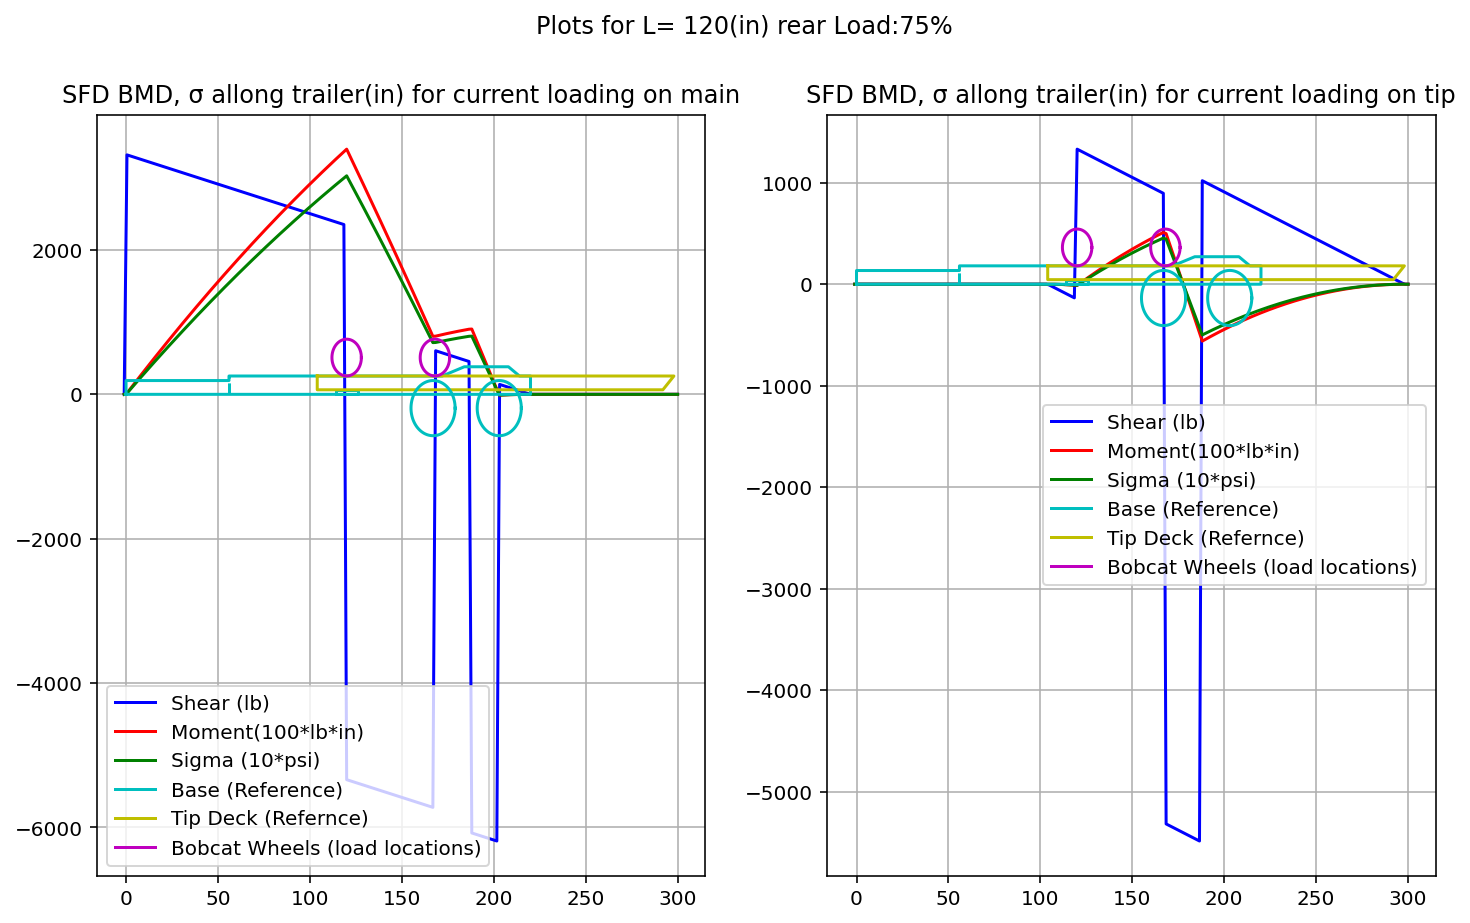

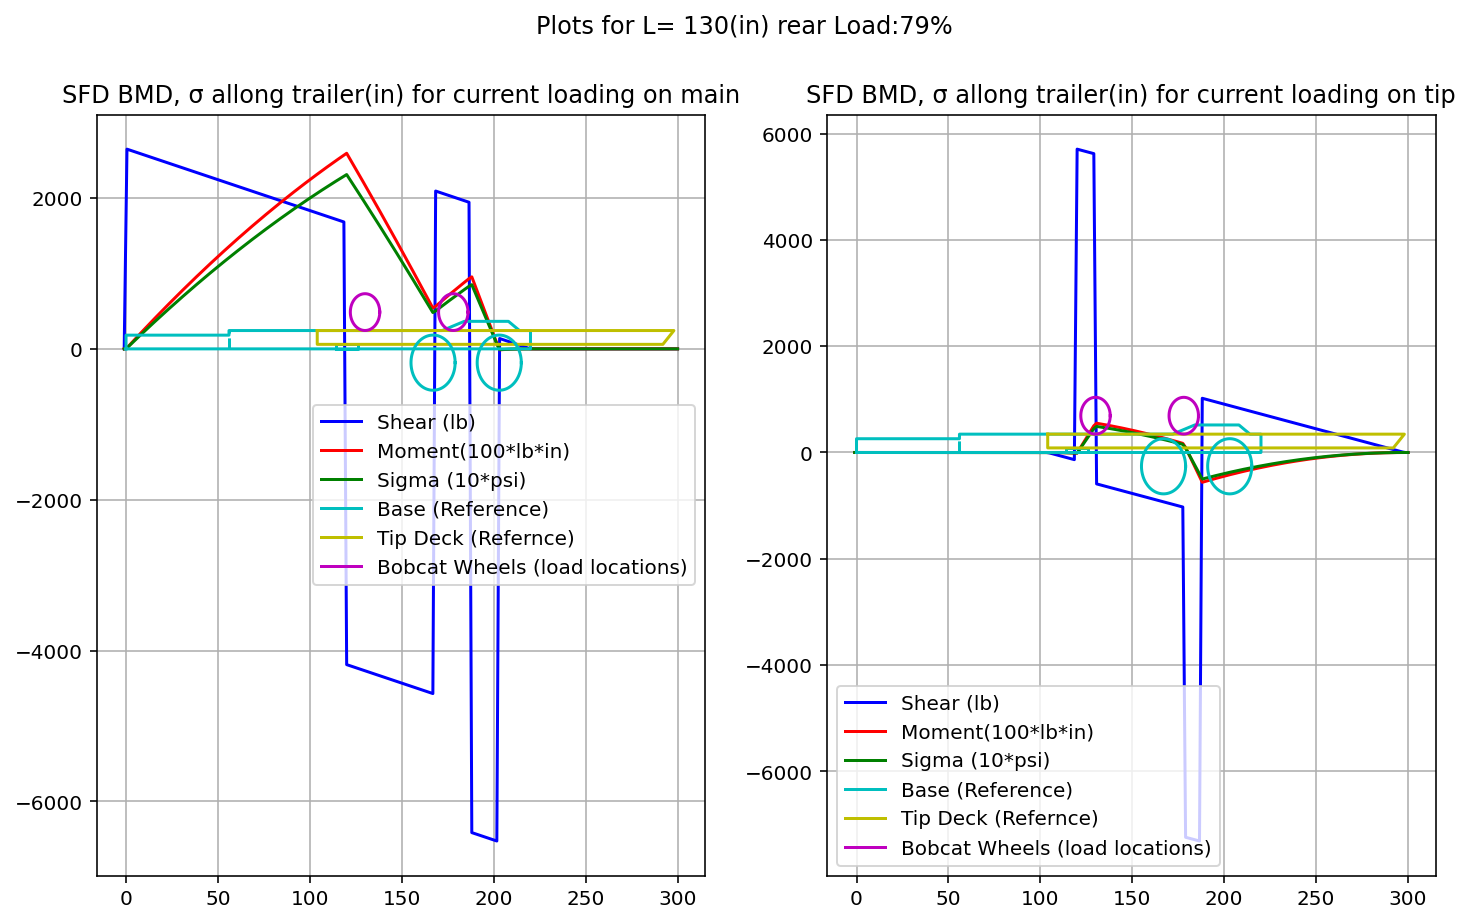

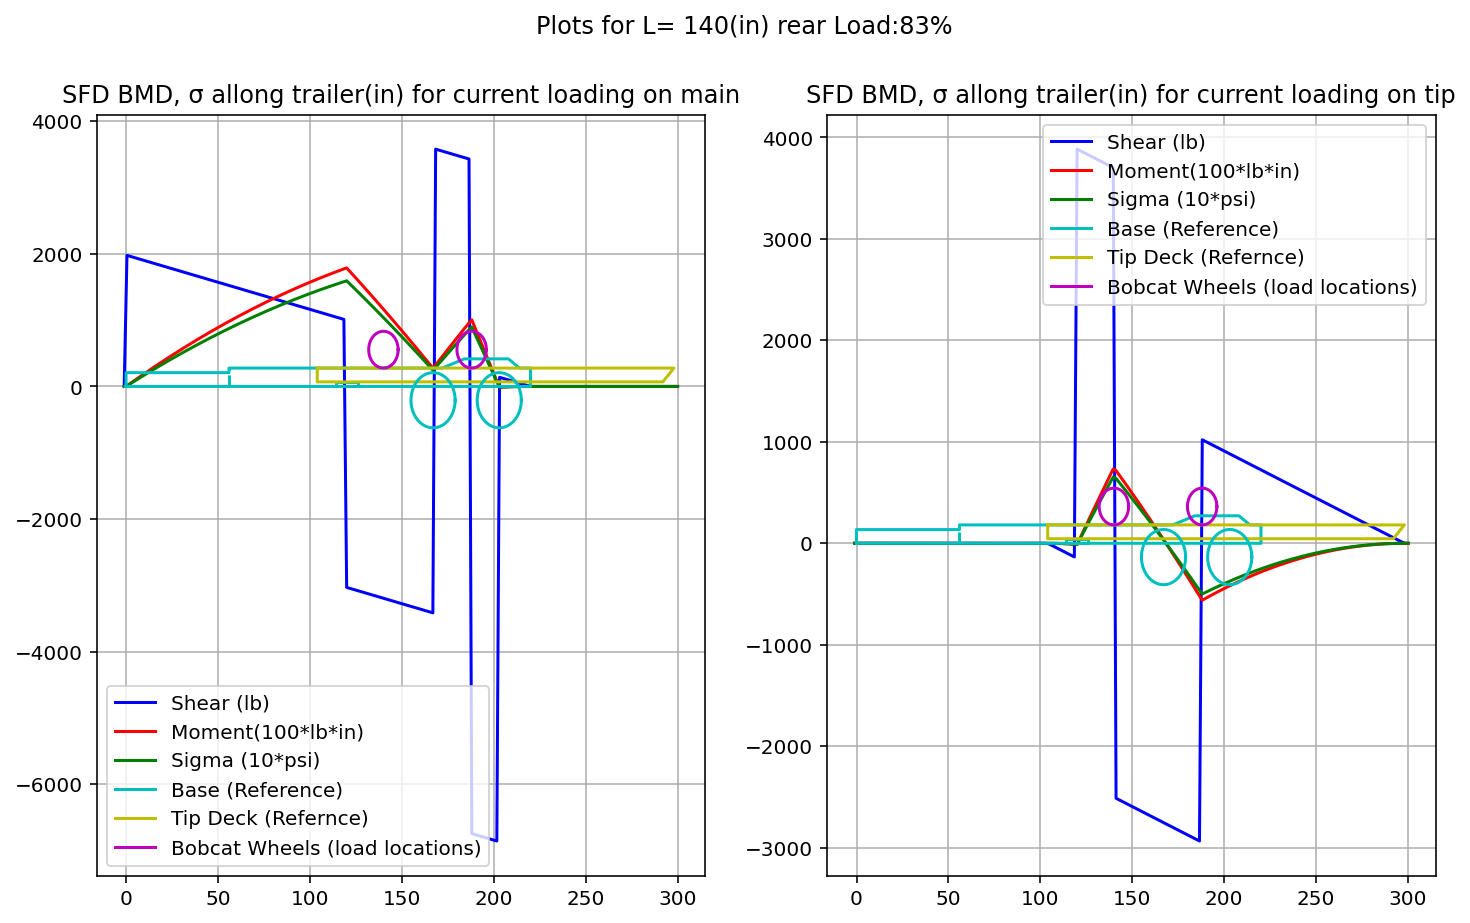

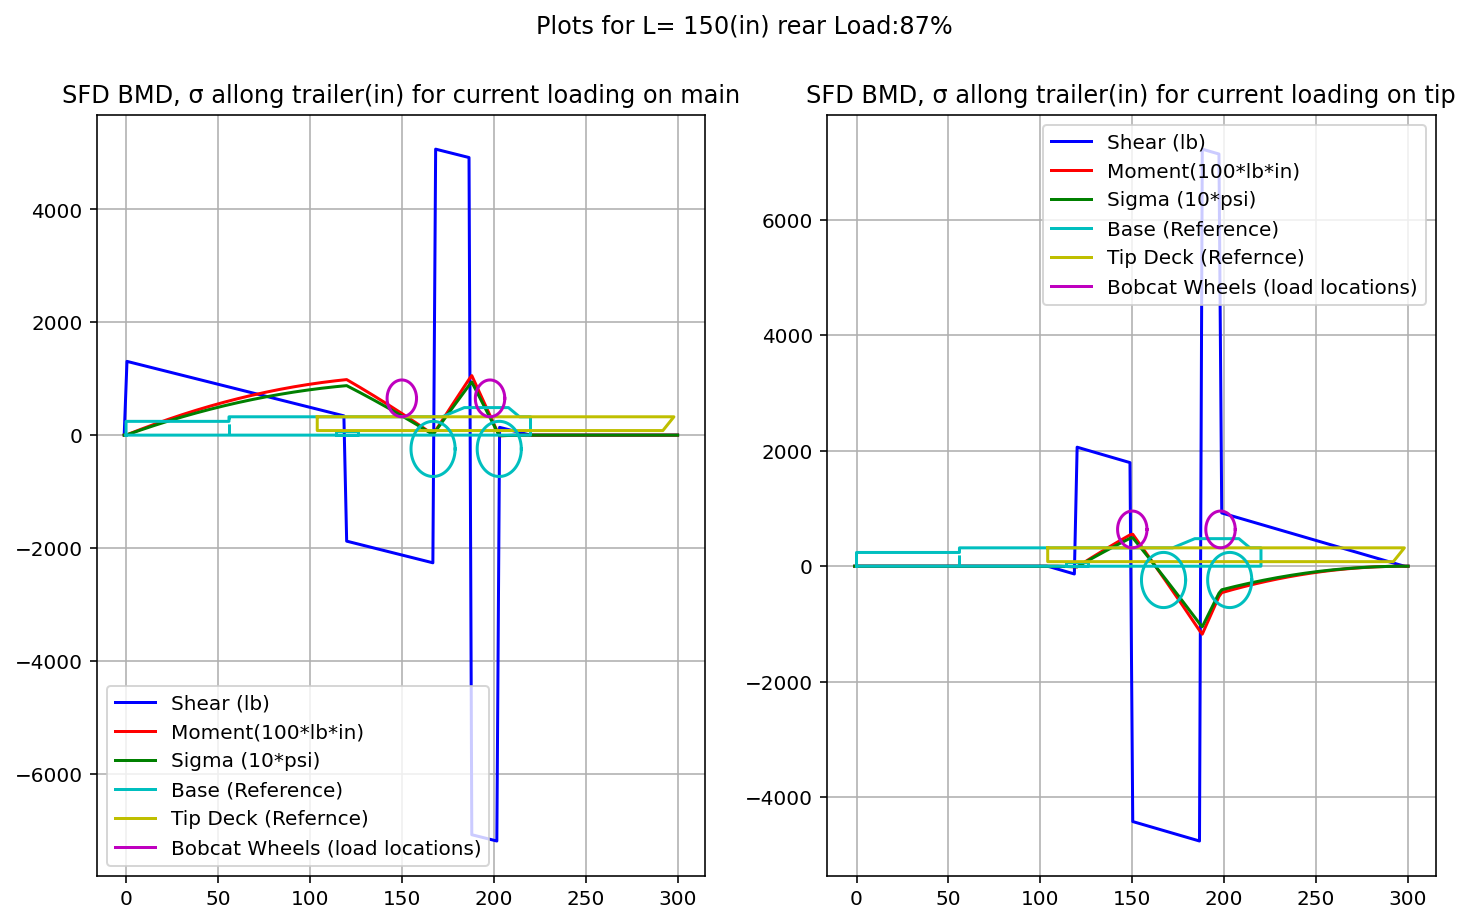

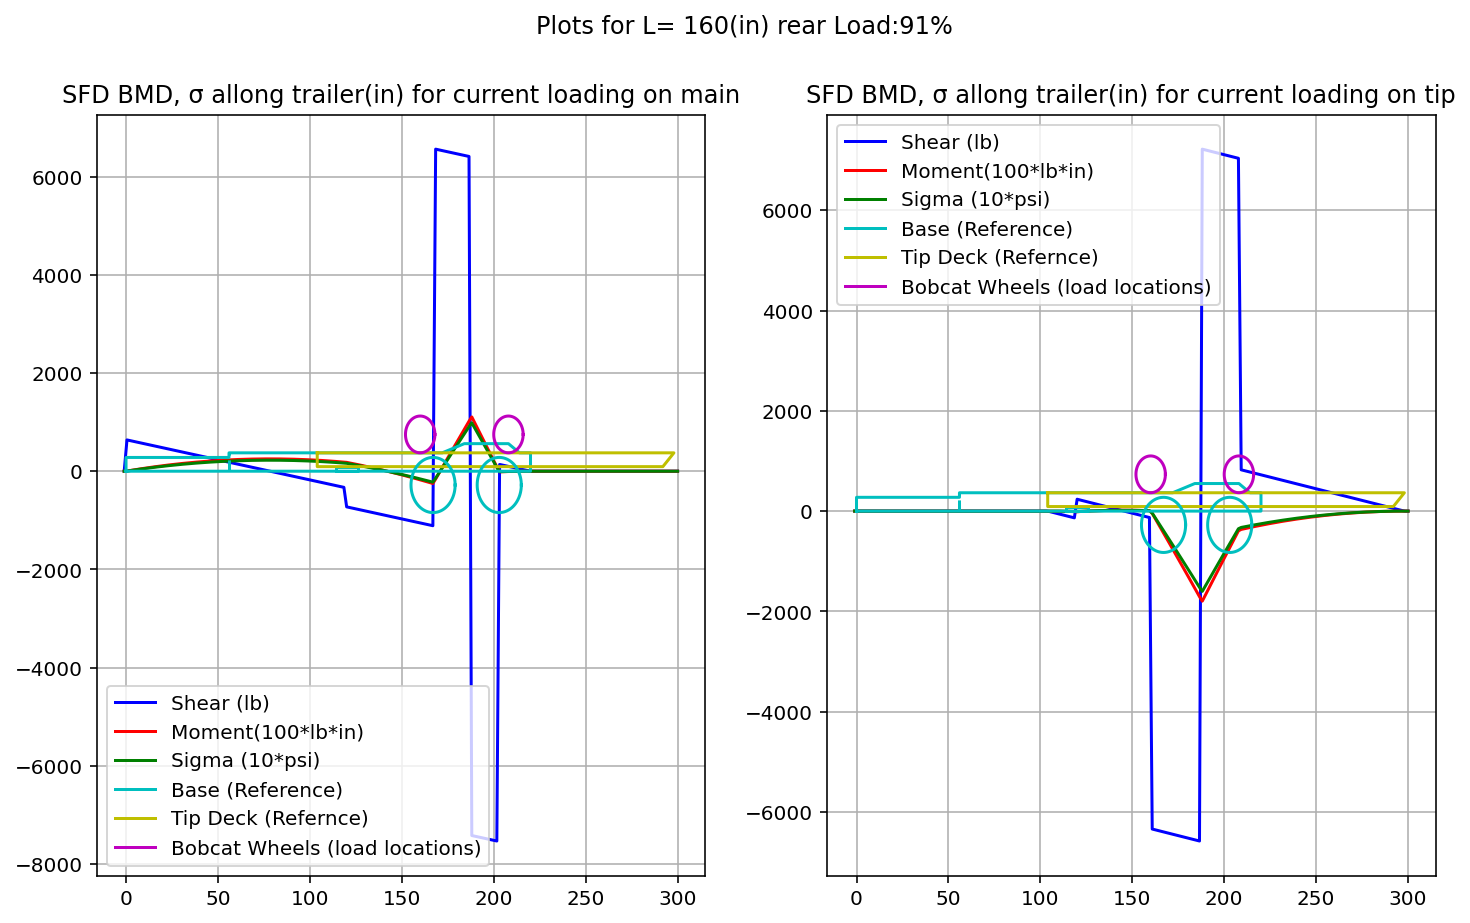

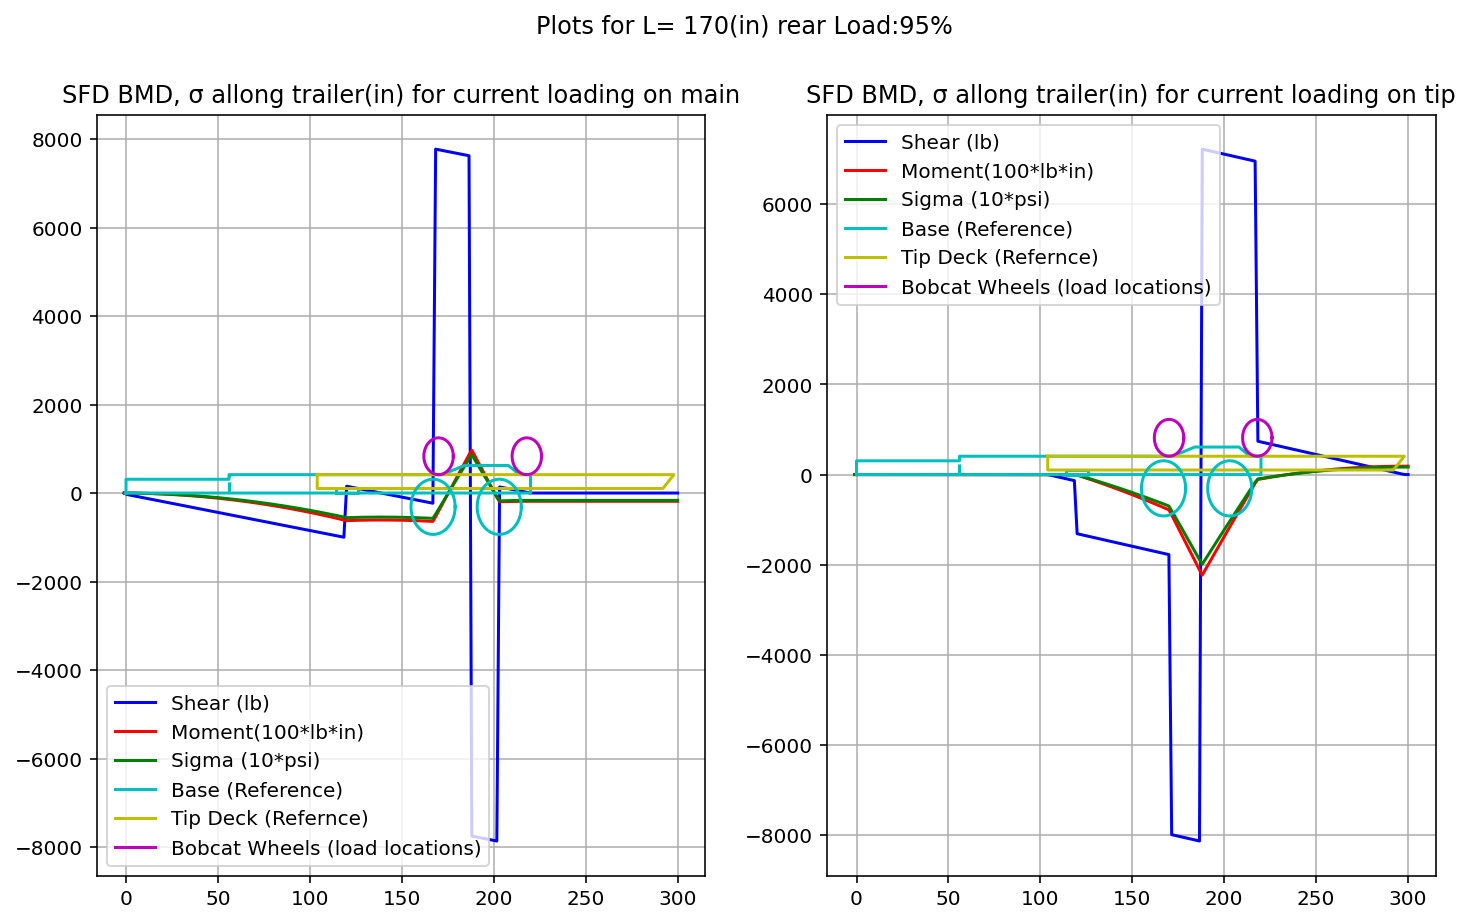

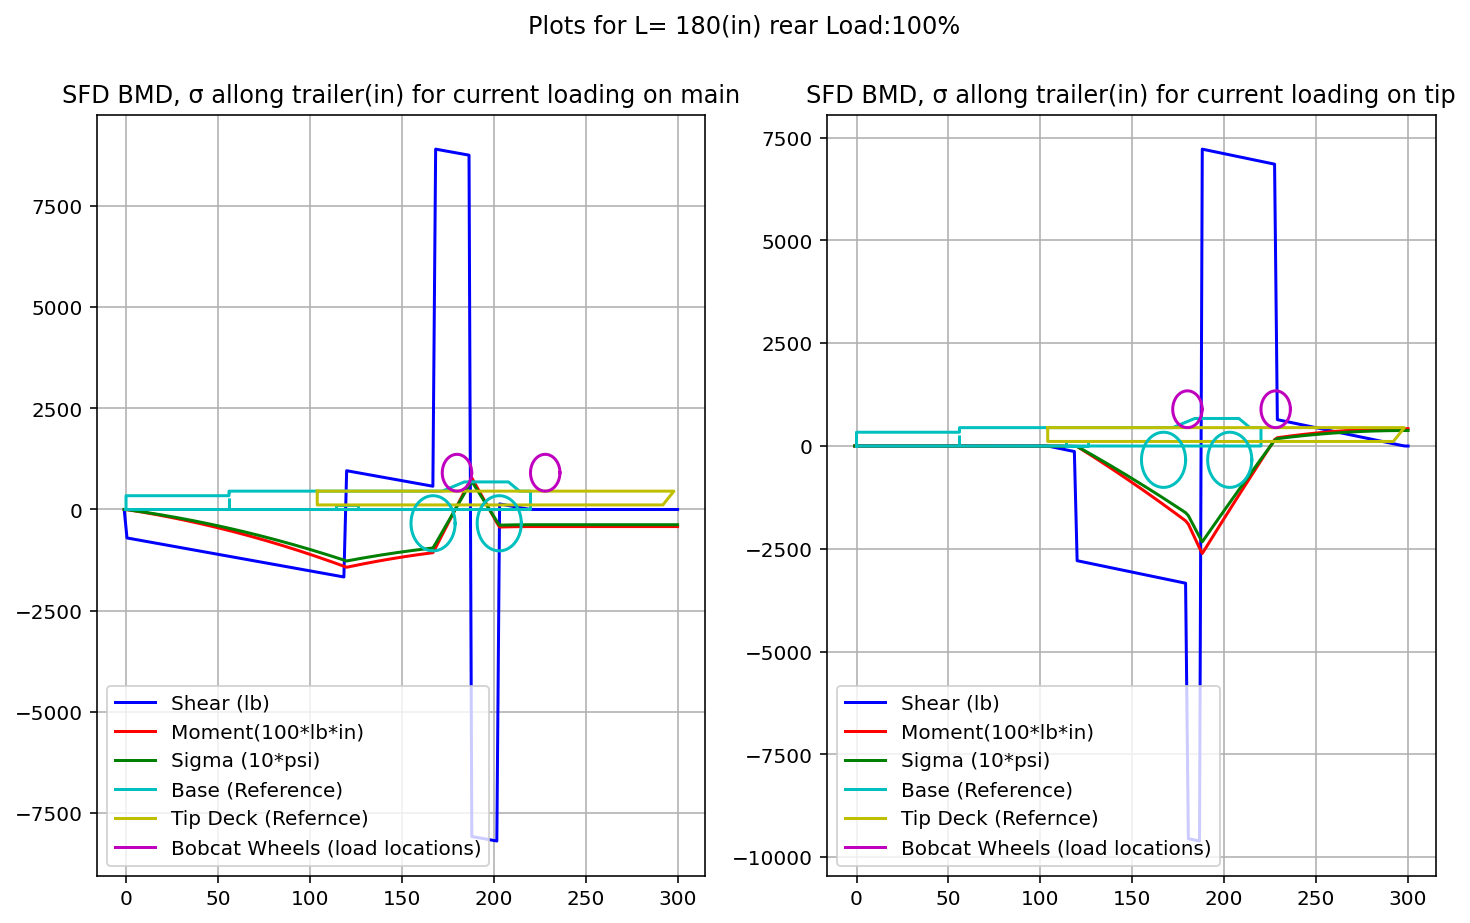

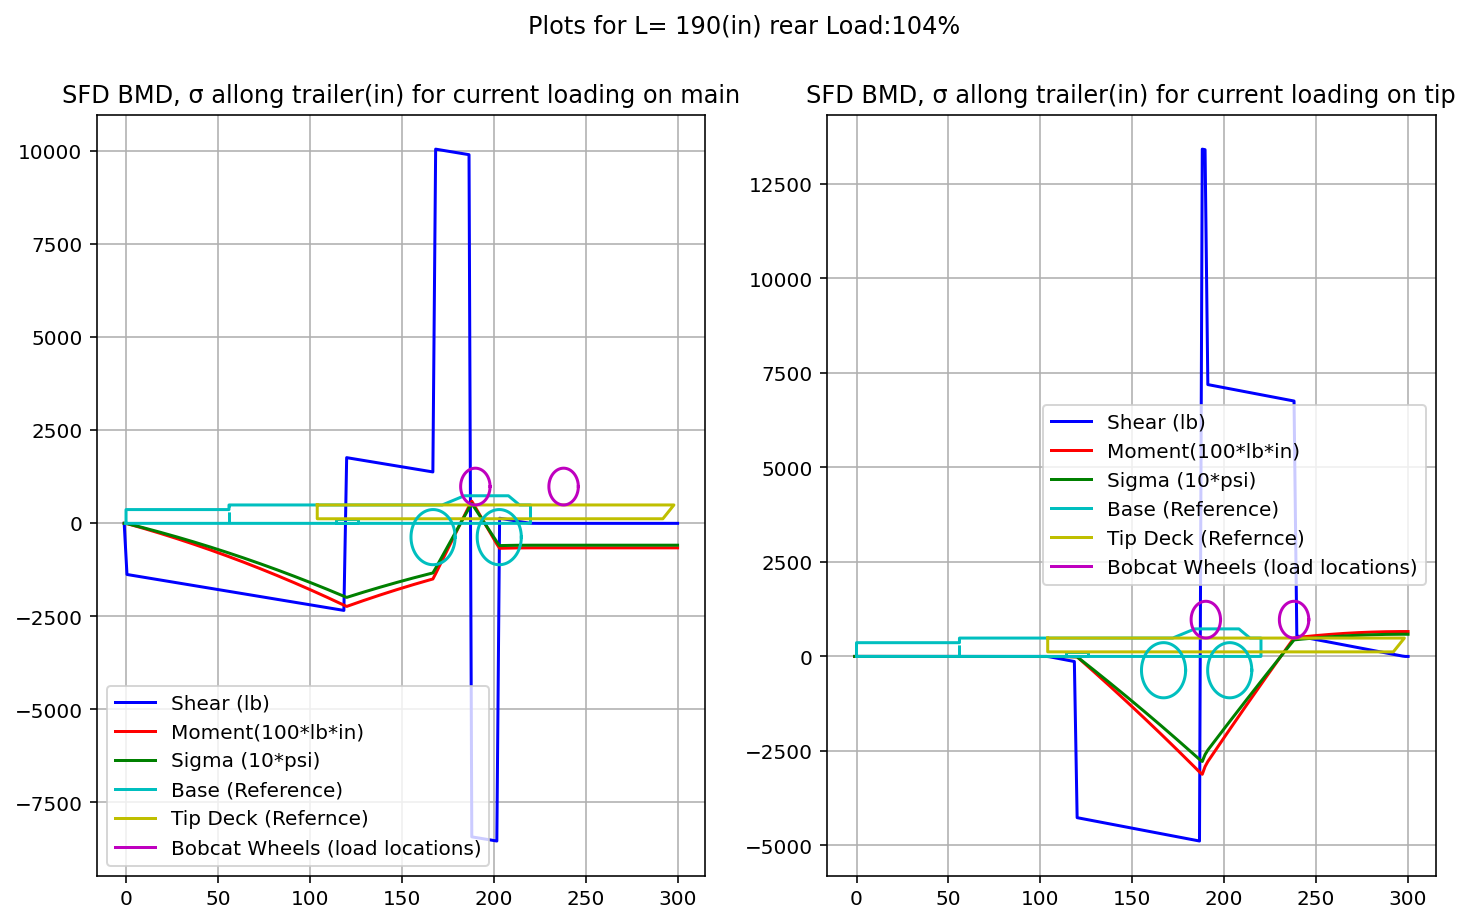

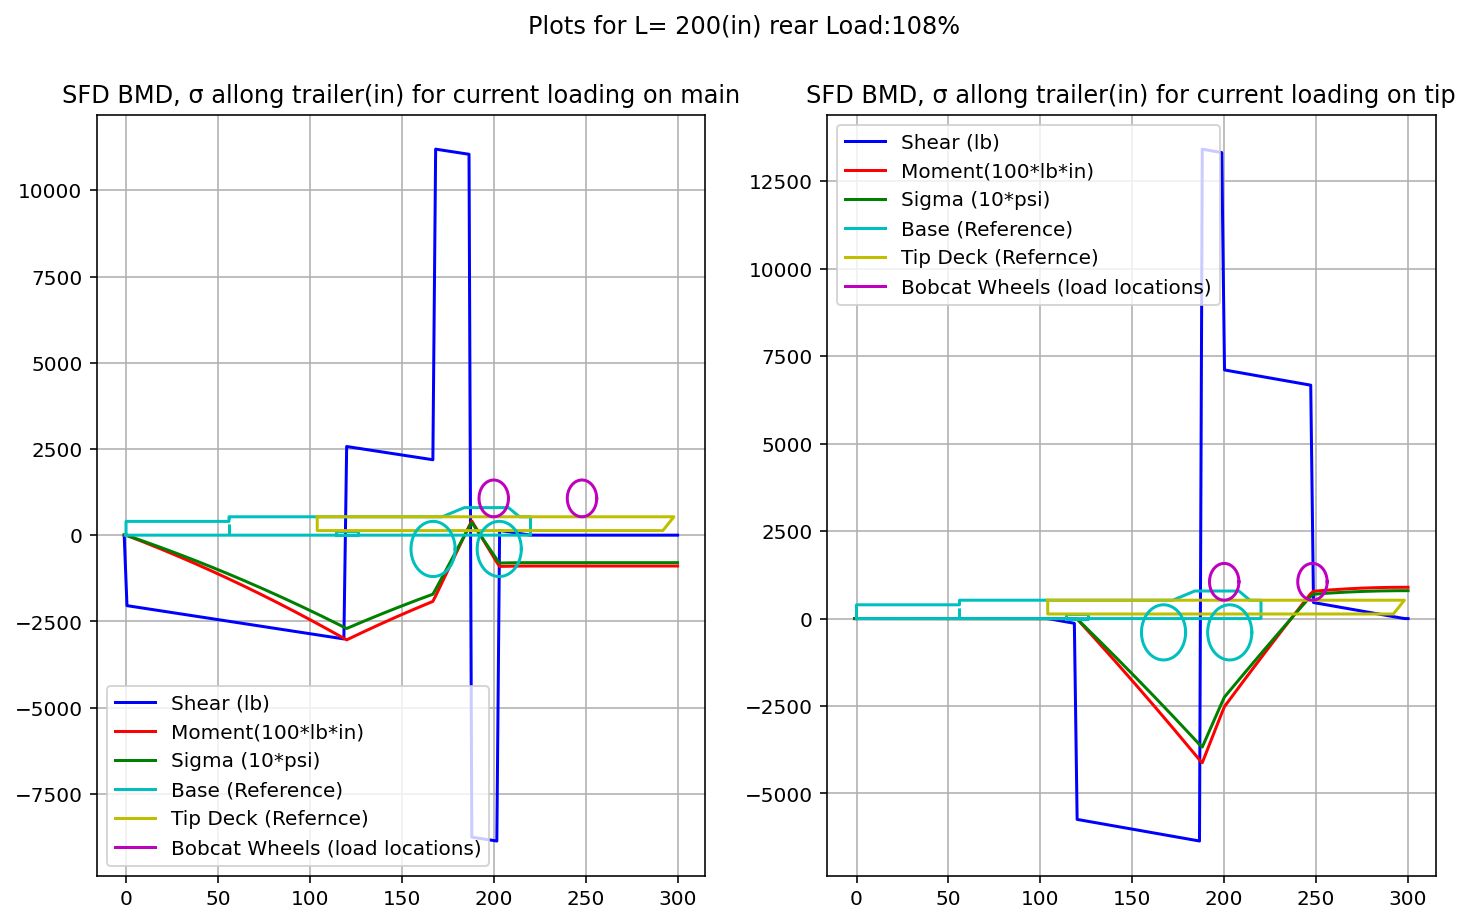

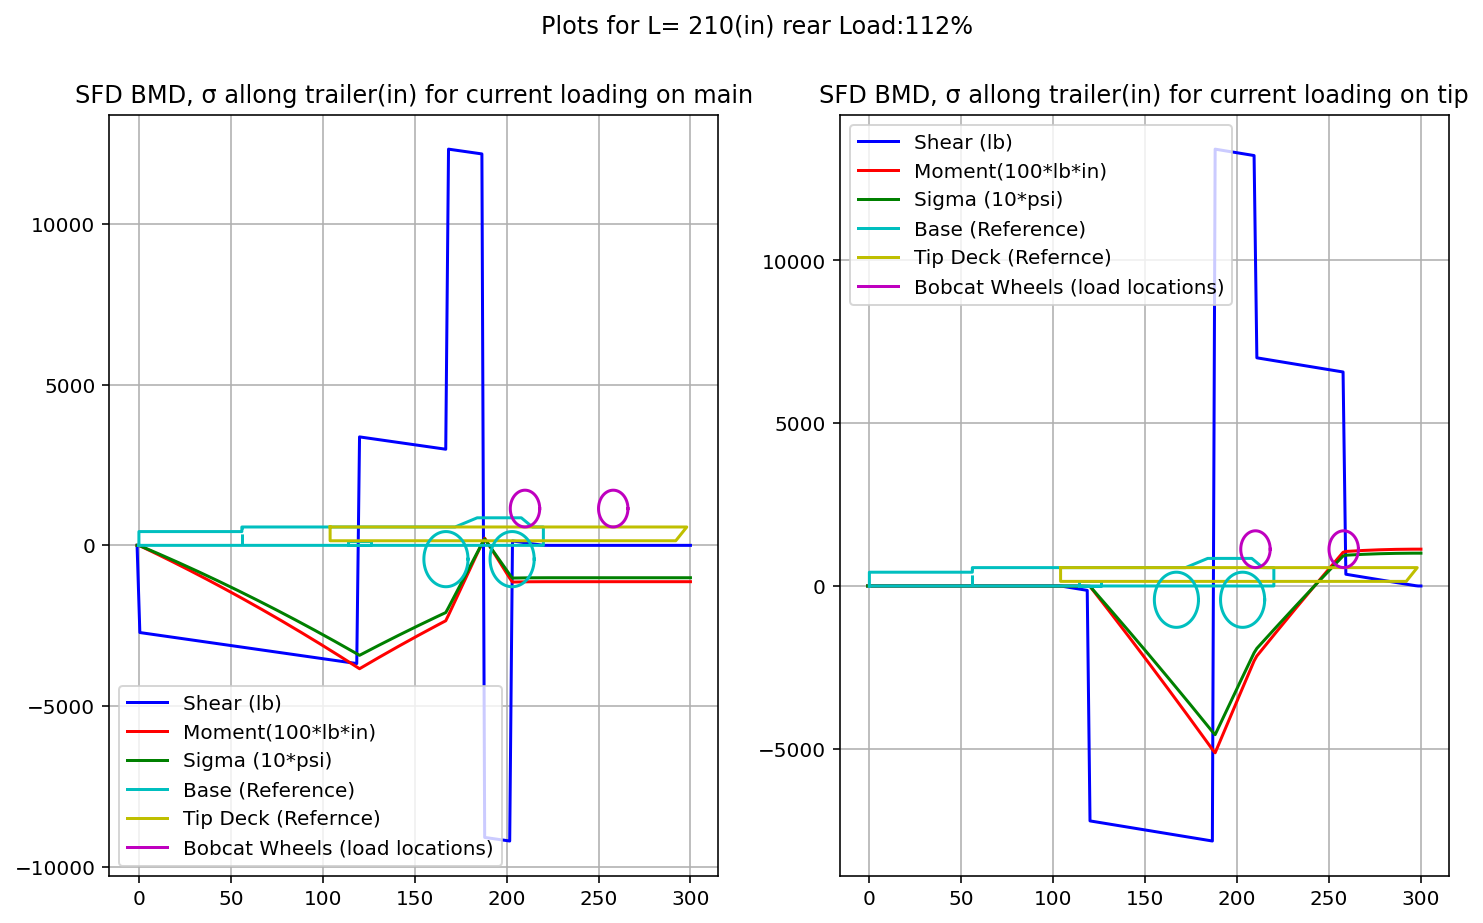

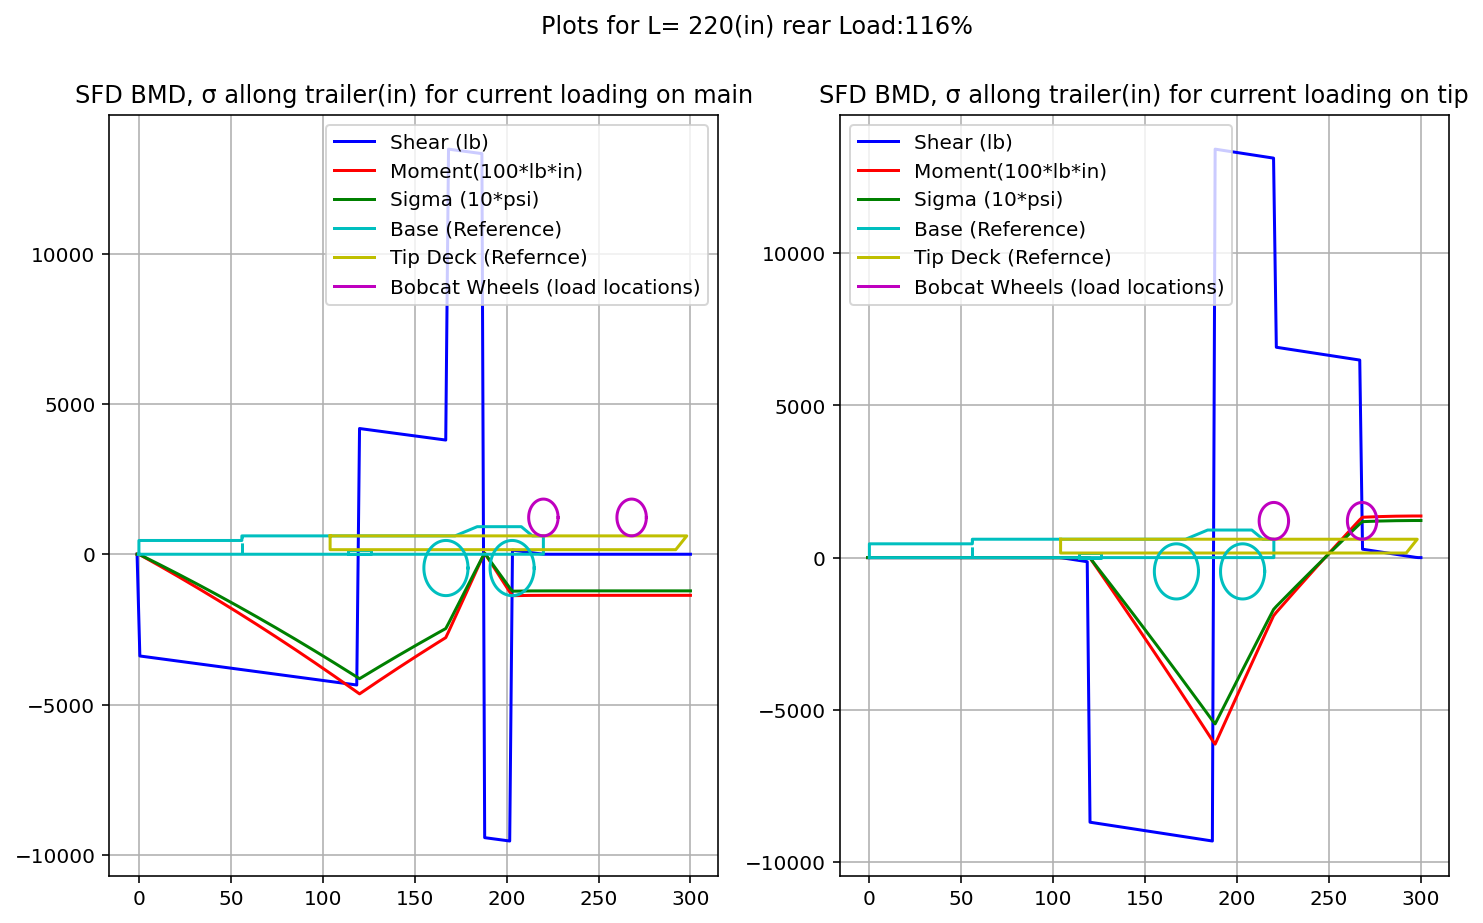

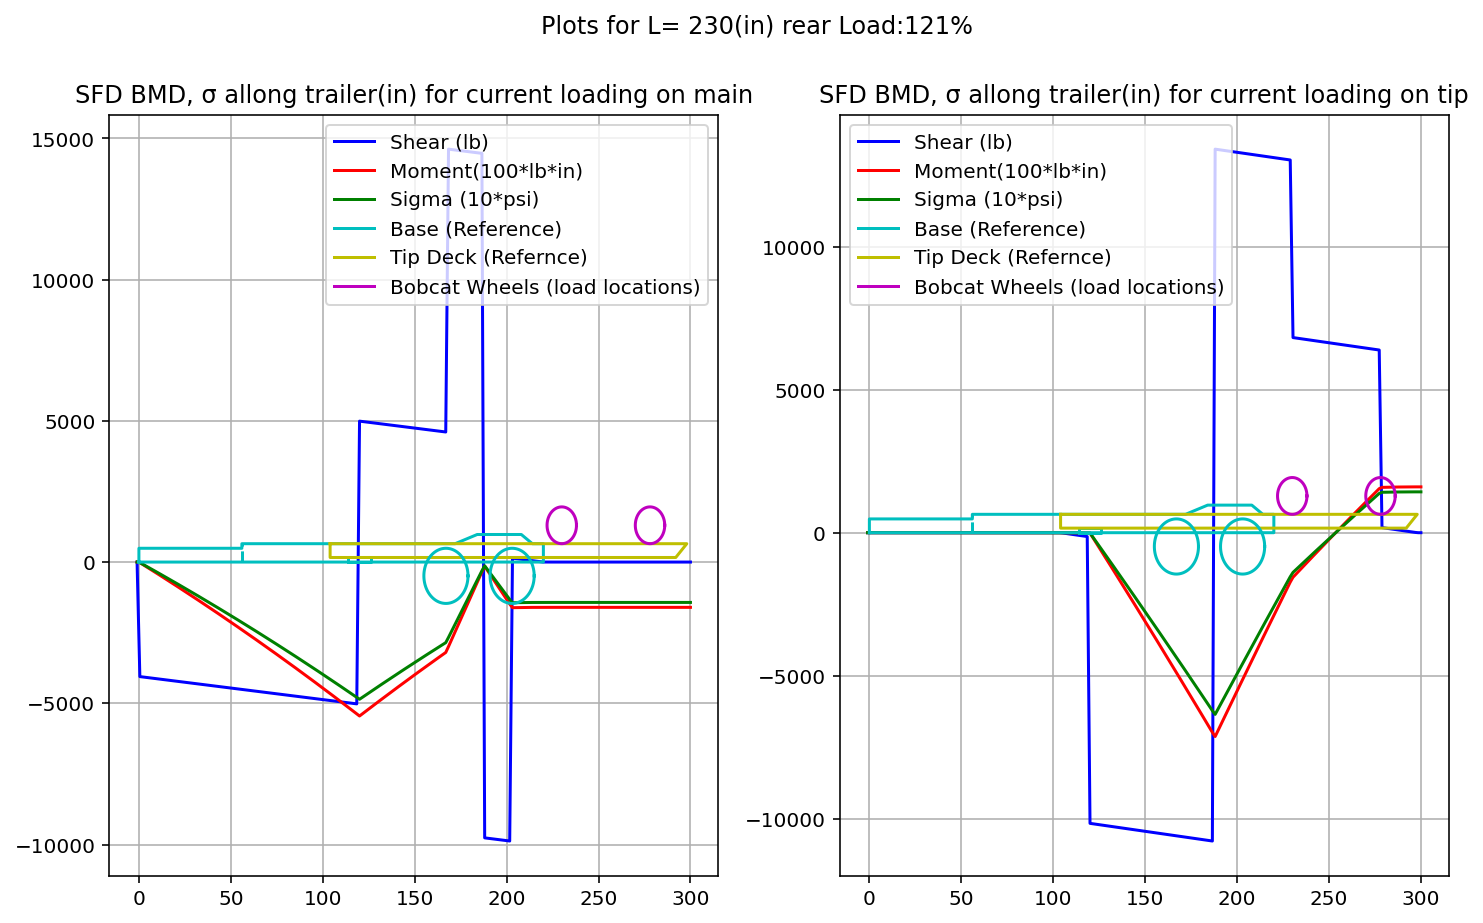

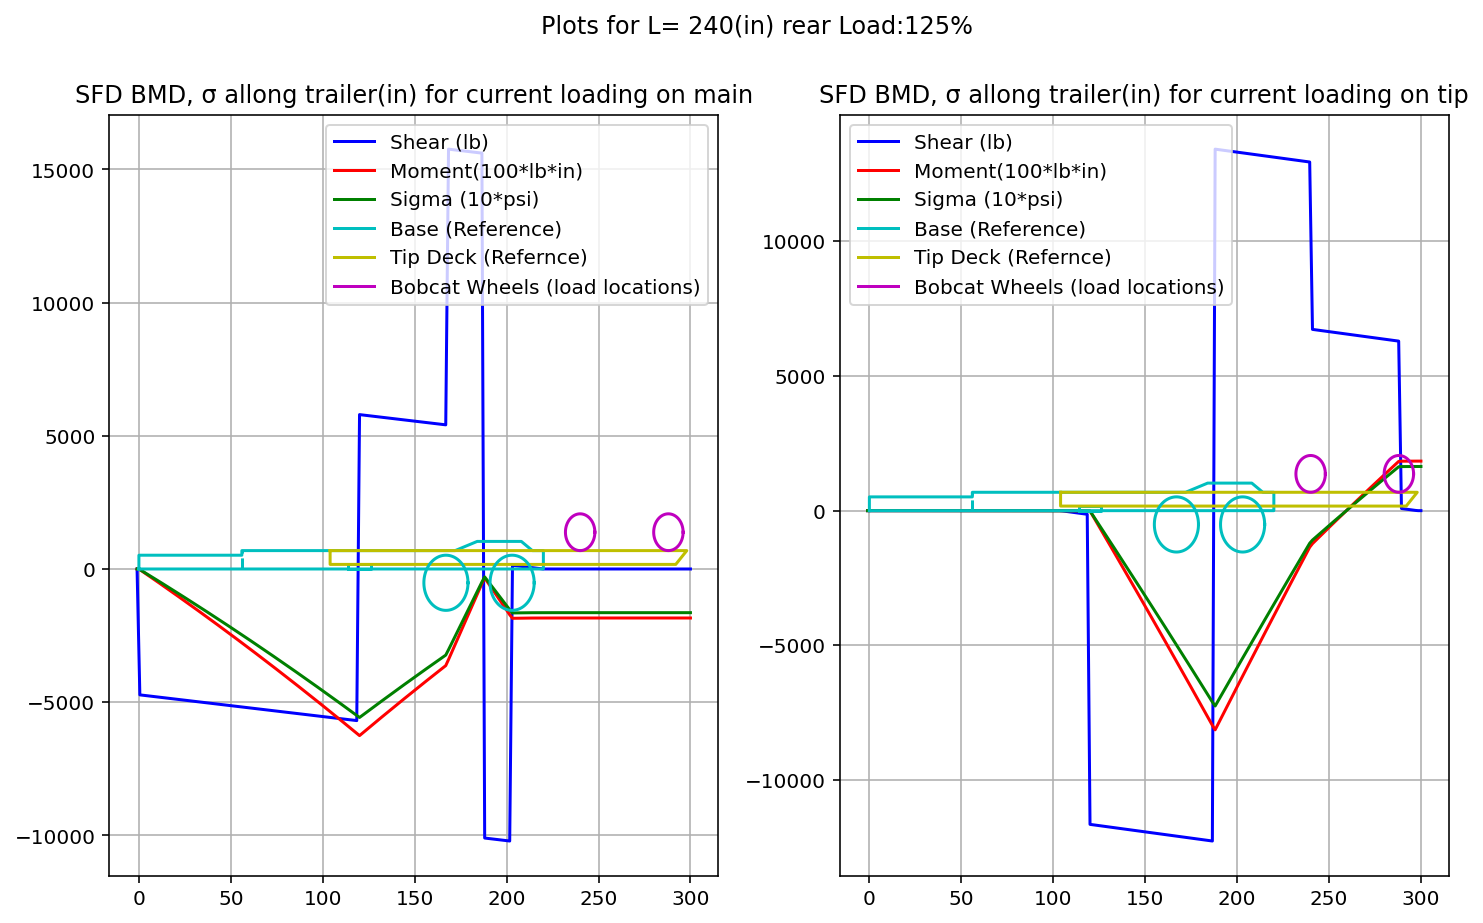

In [12]:
#test 1
#constants
yield_s = 50000
shear_mod = 5.61
shear_mod_tip=5.49

rail_cnt = 2

rail_cnt2 = 2

GVWR = 16000

W_tip = 1800 # tare/2
Rc = GVWR/2 - W_tip

lc = 200-12
a1 = 104
a0 = 56

tip_len = 194
base_len = 220

G_base = base_len / 2
G_tip = tip_len / 2 + a1

a2 = a1 + 16
lw1 = lc -21
lw2 = lc +15
lf = a1+tip_len


wheel_base = 48

react_mat1,react_mattip1,mp,fa = run_f()
plot_x(react_mat1,react_mattip1,mp,fa)
